In [241]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
#from kneed import KneeLocator
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from os import listdir
from os.path import isfile, join
import os
import datetime as dt
import scipy.io
import glob
import pyresample
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

import matplotlib.colors as colors
import matplotlib as mpl
from netCDF4 import Dataset
import IPython.display
import cmocean
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cft
#import cosima_cookbook as cc
#from mpl_toolkits.basemap import Basemap
import math
import time
import sys


def get_var_list(list_name):
    '''
    Get a list of variables associated with a pre-defined name.
    '''
    if list_name == 'ocn':
        var_list = ['sst','sss','uocn','vocn','frzmlt']
    elif list_name == 'atmo':
        var_list = ['Tair','uatm','vatm','fswdn','flwdn','snow']
    elif list_name == 'wave':
        var_list = ['aice','wave_sig_ht','peak_period','mean_wave_dir']
    elif list_name == 'ice':
        var_list = ['aice','hi','fsdrad','iage','uvel','vvel','frazil','congel']
    elif list_name == 'JRA55':
            var_list = ['airtmp']
    elif list_name == 'static':
        var_list = ['aice','hi','hs','fsdrad','sice','iage','vlvl','vrdg']
    else:
        var_list = [list_name]

    return var_list

In [38]:
# Read in the CICE data
var_name = 'static'
variable_list = get_var_list(var_name)
num_variables = np.size(variable_list)

filename =  '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-08-26.nc'
# '/Users/noahday/Gadi/ia40/waves-10/history/iceh.2002-08-26.nc' 
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
# '/Users/noahday/Gadi/ia40/waves-10/history/'
#onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
#onlyfiles.sort()
os.chdir(mypath)
onlyfiles = glob.glob("*.nc")
year = 'iceh.2002'
onlyfiles = glob.glob("{path}/*{year}*".format(path=mypath, year=year))
onlyfiles.sort()

ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values
# Get the total number of grid points
size = 1
for dim in np.shape(LN): size *= dim
aice_data = ds['aice'][0,:,:]
#mask = np.ma.masked_where(LT > 0.0, aice_data)
#mask = np.ma.masked_where(aice_data < 0.15, mask)
#mask = mask.mask
mask1 = np.ma.masked_where(LT > 0.0, aice_data)
mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
master_mask = mask1.mask | mask2.mask
mask = master_mask

X_out =  np.ma.masked_array(np.empty((size,1)), mask=mask)

file_dates = []
for filecount, file in enumerate(onlyfiles):
    #filename = mypath + file
    filename = file
    print(file)
    file_dates.append(np.datetime64(file[-13:-3]))

    ds = xr.open_dataset(filename)
    LN = ds.TLON.values
    LT = ds.TLAT.values

    aice_data = ds['aice'][0,:,:]
    
    mask1 = np.ma.masked_where(LT > 0.0, aice_data)
    mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
    master_mask = mask1.mask | mask2.mask
    mask = master_mask

    for counter, exp in enumerate(variable_list):
        data = ds[exp][0,:,:]
        data_masked = np.ma.masked_where(mask, data.values)
        data_masked_vec = data_masked.compressed()
        size, = data_masked_vec.shape

        if counter == 0: 
            X_temp = data_masked_vec.reshape(size,1)
        else:
            X_temp = np.concatenate([X_temp, data_masked_vec.reshape(size,1)],axis=1)
        
    LN_masked = np.ma.masked_where(mask, LN)
    LN_vec = LN_masked.compressed()
    LT_masked = np.ma.masked_where(mask, LT)
    LT_vec = LT_masked.compressed()
    X_temp = np.concatenate([X_temp, LN_vec.reshape(size,1), LT_vec.reshape(size,1)],axis=1)
    if filecount == 0: 
        X_out = X_temp
        datetime_vec =  np.tile(np.datetime64(file[-13:-3]),(size,1))
    else:
        X_out = np.concatenate([X_out, X_temp],axis=0)
        datetime_vec = np.concatenate([datetime_vec, np.tile(np.datetime64(file[-13:-3]),(size,1))],axis=0)
    

df_raw = pd.DataFrame(X_out, columns = variable_list+['longitude','latitude'])#,'date'])
df_raw['date'] = datetime_vec
df_raw = df_raw.dropna()


# Print the dataset

df_raw.describe()


/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-01.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-02.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-03.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-04.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-05.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-06.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-07.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-08.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-09.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-10.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-11.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-12.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-13.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-14.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2002-01-15.nc
/g/data/ia40/cice-dirs/runs/waves-10/his

,aice,hi,hs,fsdrad,sice,iage,vlvl,vrdg,longitude,latitude
count,2.102701e+06,2.102701e+06,2.102701e+06,2.102701e+06,2.102701e+06,2.102701e+06,2.102701e+06,2.102701e+06,2.102701e+06,2.102701e+06
mean,9.405425e-01,9.531218e-01,1.587670e-01,3.672556e+02,7.834429e+00,2.926009e-01,4.680405e-01,4.850814e-01,2.069059e+02,-6.829437e+01
std,1.435548e-01,5.961332e-01,1.325653e-01,3.328596e+02,3.853992e+00,2.062515e-01,2.732617e-01,5.351155e-01,1.025431e+02,5.258752e+00
min,1.500006e-01,5.868570e-03,0.000000e+00,5.600842e-01,2.886546e+00,4.849794e-04,4.066559e-04,1.385185e-10,5.000000e-01,-7.762990e+01
25%,9.656218e-01,4.882567e-01,5.107044e-02,7.268181e+00,5.224480e+00,1.332320e-01,2.648246e-01,1.240025e-01,1.515000e+02,-7.243740e+01
50%,9.968919e-01,8.689201e-01,1.229105e-01,3.238331e+02,6.691412e+00,2.554881e-01,4.256726e-01,3.272462e-01,2.085000e+02,-6.870660e+01
75%,9.995332e-01,1.346725e+00,2.443780e-01,7.252983e+02,9.132843e+00,4.118195e-01,6.330022e-01,6.498680e-01,3.075000e+02,-6.444659e+01
max,1.000000e+00,5.520805e+00,1.242451e+00,8.504769e+02,3.094102e+01,3.121833e+00,1.515589e+00,5.432934e+00,3.595000e+02,-5.303830e+01


In [39]:




#X_out

#mask.shape
#aice_data.shape

#aice_data[mask]

#import glob, os
#os.chdir(mypath)
#for file in glob.glob("*.nc"):
#    print(file)

#onlyfiles = glob.glob("*.nc")
#onlyfiles

mask1 = np.ma.masked_where(LT > 0.0, aice_data)
mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
#mask = mask.mask
print(mask1.mask)
print(mask2.mask)

master_mask = mask1.mask | mask2.mask
master_mask



[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
#X_temp.mask[1,:]
#temp_vec

#data
#temp_vec = data.reshape(size,1)
#temp_vec2 = np.ma.masked_array(temp_vec, mask=mask)

#temp_vec.data
data = ds[exp][0,:,:]
#print(data)
data.values[1,:]

data_masked = np.ma.masked_where(LT > 0.0, data.values)
data_masked = np.ma.masked_where(aice_data < 0.15, data_masked)
data_masked_vec = data_masked.compressed()
#print(data)
#data_masked_vec = data_masked.data.reshape((size,1))
#print(data_masked_vec.shape)
#data_masked_vec

data4[20:10000]

data4.shape
#data2.data[1,:]

In [ ]:
# Get row index and dates

mask1= (df_raw['date'] == file_dates[0])
mask2 = (df_raw['date'] == file_dates[2])

print(mask1[1:100])
print(mask2[-100:-1])
#

In [ ]:

X_train = df_raw['aice'].values
len = X_train.shape
len


Text(0.5, 1.0, 'Log-Min/Max')

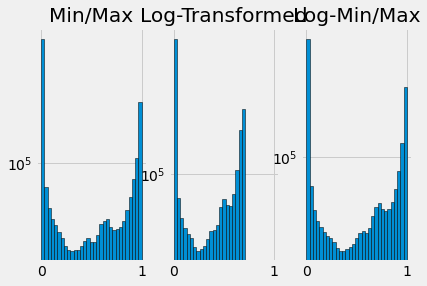

In [39]:
# Standardisation
X_train = df_raw['fsdrad'].values
len, = X_train.shape


min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train.reshape(len,1))


#create log-transformed data
X_log = np.log(X_train_minmax+1)
scaler = StandardScaler()
#scaled_features = scaler.fit_transform(X_standardized)

X_log_minmax = min_max_scaler.fit_transform(X_log.reshape(len,1))


#define grid of plots

fig, axs = plt.subplots(nrows=1, ncols=3)

#create histograms

axs[0].hist(X_train_minmax, edgecolor='black',bins=31,log=True,range=[0, 1])
axs[1].hist(X_log, edgecolor='black',bins=31,log=True,range=[0, 1])
axs[2].hist(X_log_minmax, edgecolor='black',bins=31,log=True,range=[0, 1])


#add title to each histogram
axs[0].set_title('Min/Max')
axs[1].set_title('Log-Transformed')
axs[2].set_title('Log-Min/Max')
    


In [40]:
# Standardise all the variables

X_temp = df_raw['aice'].values
len, = X_temp.shape
row_index = len
X_train = np.zeros((row_index,1))
for counter, exp in enumerate(variable_list):
    X_temp_vec = df_raw[exp].values

    min_max_scaler = preprocessing.MinMaxScaler()
    X_temp_vec = min_max_scaler.fit_transform(X_temp_vec.reshape(row_index,1))

    #create log-transformed data
    X_temp_vec = np.log(X_temp_vec+1)
    scaler = StandardScaler()
    #scaled_features = scaler.fit_transform(X_standardized)
    X_temp_vec = min_max_scaler.fit_transform(X_temp_vec.reshape(row_index,1))
    X_train = np.concatenate([X_train, X_temp_vec],axis=1)

temp_lon = df_raw['longitude'].to_numpy()
temp_lat = df_raw['latitude'].to_numpy()
X_train = np.concatenate([X_train, temp_lon.reshape(row_index,1), temp_lat.reshape(row_index,1)],axis=1)
X_train=np.delete(X_train,0,1)

df_standard = pd.DataFrame(X_train, columns = variable_list+['longitude','latitude'])
#df_standard['date'] = df_raw['date']#np.datetime64(file_date)
df_standard['date'] = df_raw['date'].values


print(df_standard.describe())
df_standard

print(df_standard['date'])



               aice            hi            hs        fsdrad          sice  \
count  2.102701e+06  2.102701e+06  2.102701e+06  2.102701e+06  2.102701e+06   
mean   9.416196e-01  2.228152e-01  1.673439e-01  4.626576e-01  2.255890e-01   
std    1.517866e-01  1.287203e-01  1.316323e-01  3.985282e-01  1.545183e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    9.705259e-01  1.209747e-01  5.811496e-02  1.134193e-02  1.154801e-01   
50%    9.973599e-01  2.097571e-01  1.360940e-01  4.650429e-01  1.834854e-01   
75%    9.996036e-01  3.139794e-01  2.590499e-01  8.896422e-01  2.900101e-01   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

               iage          vlvl          vrdg     longitude      latitude  
count  2.102701e+06  2.102701e+06  2.102701e+06  2.102701e+06  2.102701e+06  
mean   1.265352e-01  3.748345e-01  1.181381e-01  2.069060e+02 -6.829438e+01  
std    8.466300e-02  1.938398e-01  1.196039e-01  1.026

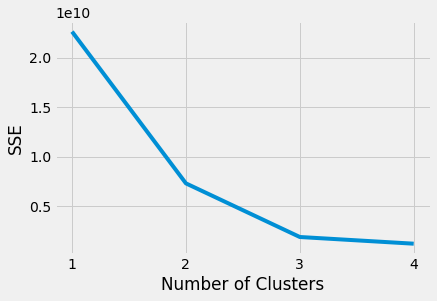

In [26]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)
#print(df_standard.iloc[:, 3] )
del X_train
X_train = df_standard.iloc[:, 0:-3] 
X_train
kmeans.fit(X_train)

# The lowest SSE value
kmeans.inertia_

# Final locations of the centroid
kmeans.cluster_centers_

# The number of iterations required to converge
kmeans.n_iter_
kmeans.labels_[:5]


kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train)
    sse.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 5), sse)
plt.xticks(range(1, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


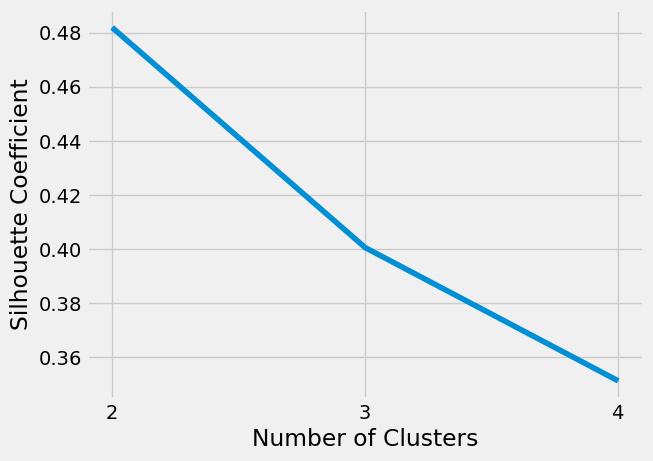

In [46]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train)
    score = silhouette_score(X_train, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 5), silhouette_coefficients)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [251]:
# Initial centroid
#0.0123    0.0054    0.0009    0.0077    0.0139    0.0075    0.0013    0.0048
#0.9825    0.4804    0.2950    0.9470    0.5100    0.2033    0.3641    0.3532
#0.9432    0.1913    0.0802    0.7402    0.6518    0.0914    0.2116    0.0867

init_centroids = np.array([[0.223, 0.0054, 0.0009, 0.0007, 0.0139, 0.0075, 0.0013, 0.0048], [0.9825, 0.4804, 0.2950, 0.9470, 0.5100, 0.2033, 0.3641, 0.3532], [0.9432, 0.1913, 0.0802, 0.7402, 0.6518, 0.0914, 0.2116, 0.0867]])

kmeans = KMeans(
    init="random",
#    init=init_centroids,
    n_clusters=3,
    n_init=10, #10,
    max_iter=300,
    random_state=2020
)
X_train = df_standard.iloc[:, 0:4] 
kmeans.fit(X_train)
#kmeans.cluster_centers_ = init_centroids

#kmeans.predict(X_train) 

df_kmeans = df_standard
df_kmeans['k'] = kmeans.labels_

print(kmeans.cluster_centers_)
df_kmeans.to_csv('kmeans.csv', index=False)

[[0.90852649 0.13814861 0.10584407 0.0461635 ]
 [0.96369349 0.28025765 0.18523576 0.91465331]
 [0.9698971  0.2934603  0.26055377 0.51235654]]


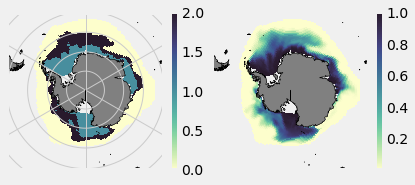

In [253]:
filename
ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values

date_idx = df_kmeans['date'] == '2002-09-01'

lon = df_kmeans['longitude'][date_idx];
lat = df_kmeans['latitude'][date_idx];
k = df_kmeans['k'][date_idx];
ra = df_kmeans['fsdrad'][date_idx];

row_length = date_idx.sum()
lon = lon.values.reshape(row_length,1)
lat = lat.values.reshape(row_length,1)
k = k.values.reshape(row_length,1)
ra = ra.values.reshape(row_length,1)

k_means_array = np.empty(LN.shape)
k_means_array[:] = np.nan

fsdrad_array = np.empty(LN.shape)
fsdrad_array[:] = np.nan

lats = LT
lons = LN

for row_lp in range(0, row_length):
    a = abs(lats-lat[row_lp])+abs(lons-lon[row_lp])
    i,j = np.unravel_index(a.argmin(),a.shape)
    k_means_array[i,j] = k[row_lp]
    fsdrad_array[i,j] = ra[row_lp]

fontprops = fm.FontProperties(size=18)
plt.figure()
cmap = cmo.deep
coord_lims = [-180, 180, -50, -90]

ax = plt.subplot(1, 2, 0+1, projection=ccrs.SouthPolarStereo(), label='{0}'.format(counter))
ax.set_extent(coord_lims, ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(LN, LT, k_means_array,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)
gl = ax.gridlines(draw_labels=False)
#scalebar = AnchoredSizeBar(ax.transData,
#                           100000, '100 km', 'lower center', 
#                           pad=0.1,
#                           color='black',
#                           frameon=False,
#                           size_vertical=1,
#                           fontproperties=fontprops)
#
#ax.add_artist(scalebar)
#plt.savefig('kmean.png', dpi = 300)  

ax = plt.subplot(1, 2, 0+2, projection=ccrs.SouthPolarStereo(), label='{0}'.format(counter))
ax.set_extent(coord_lims, ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(LN, LT, fsdrad_array,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)
#scalebar = AnchoredSizeBar(ax.transData,
#                           100000, '100 km', 'lower center', 
#                           pad=0.1,
#                           color='black',
#                           frameon=False,
#                           size_vertical=1,
#                           fontproperties=fontprops)
#ax.add_artist(scalebar)
plt.savefig('kmean.png', dpi = 300)  



[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


Indices of nearest neighbours: (array([86, 88, 90]), array([134, 316, 138]))
Longitude of nearest neighbours: [214.5  36.5 218.5]
Latitude of nearest neighbours: [-21.000265 -19.365053 -17.8596  ]
Great Circle Distance: [ 7221.824 18563.826 15618.705]
56
49
129.5
-49.6309


TypeError: Dimensions of C (8770, 1) are incompatible with X (8770) and/or Y (8771); see help(pcolormesh)

/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value

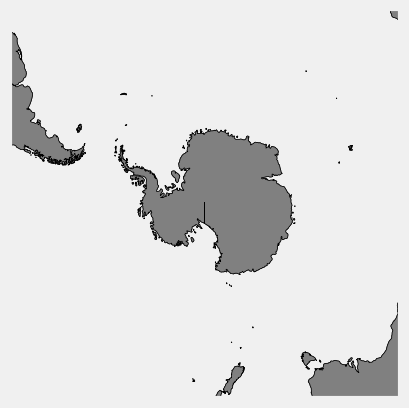

In [53]:
#print(k.shape)

plt.figure()
cmap = cmo.deep
coord_lims = [-180, 180, 90, -90]
ax.set_extent(coord_lims, ccrs.PlateCarree())
ax = plt.subplot(1, 1, 0+1, projection=ccrs.SouthPolarStereo(), label='{0}'.format(counter))
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(lon, lat, k,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)
plt.savefig('kmean.png', dpi = 300)  

#k
#filename










len_tmp, = kmeans.labels_.shape
kmean_datavec = kmeans.labels_.reshape((len_tmp,1))

coord_lims = [-180, 180, -40, -90]
ax = plt.subplot(1, 1, 0+1, projection=ccrs.SouthPolarStereo(), label='{0}'.format(counter))
#print('     ' + exp)
#ax= plot_map(ax,exp,ds,LN,LT)
#ax = plt(projection=ccrs.SouthPolarStereo())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
ax.set_extent(coord_lims, ccrs.PlateCarree())
#gl = ax.gridlines(draw_labels=False)
sic_threshold = 0.05 
aice_data = ds['aice'][0,:,:]

plot_data = aice_data #ds[exp][0,:,:]
plot_data = np.ma.masked_where(aice_data < sic_threshold, plot_data)

cmap = cmo.deep
#cmap = cmap.reversed()

#p1 = ax.pcolormesh(LN,LT,plot_data, 
p1 = ax.pcolormesh(df_standard['longitude'],df_standard['latitude'], kmean_datavec,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
               # norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p1, orientation='vertical', fraction=0.046, pad=0.04)
#fontsize = 6
#cb.ax.set_ylabel( ds[exp].attrs["long_name"].partition(' of ')[0] + ' [' +  ds[exp].attrs["units"] + ']' , size=fontsize);
#cb.ax.tick_params(labelsize=fontsize) 


In [ ]:
kmeans.labels_.shape

kmean_datavec.shape